# Optimization and Regularization


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Layer and Model
The Layer and Model class are largely the same as last week. We additionally added a regularizer to our layers weights and have 5 neurons/layer.

In [ ]:
class Dense_Layer(tf.keras.layers.Layer): # .Dropout was not effective for regularization
    """DenseLayer represents a Layer in our Network, inherits from keras.layer.Layer."""
    
    
    def __init__(self, units=256, activation=tf.nn.sigmoid):
        """
        Constructor, calls super Constructor, initializes layer with 256 units and activation function sigmoid.
        ## Params
            - units = units in hidden layer (standard=256)
            - activation = activation function (standard=sigmoid)
        """
        super(Dense_Layer, self).__init__()
        self.units = units
        self.activation = activation
    
    
    def build(self, input_shape): 
        """
        Sets the weights of our network to random, sets an input shape and makes weights trainable.
        ## Params
            - input_shape = input shape for network
        """
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 regularizer=tf.keras.regularizers.l1_l2, # avoid overfitting: apply L2 regularization penalty on the layer's weights
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
  

    def call(self, inputs):
        """
        Update weights/biases of each neuron
        ## Params
            - inputs = inputs for neurons
        """
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x
    
class MyModel(tf.keras.Model):
    """MyModel represents a Tensorflow Model, inherits from keras.Model."""
    
    
    def __init__(self):
        """Constructor, calls super Constructor, initializes 2 hidden layers and an output layer."""
        super(MyModel, self).__init__()
        self.hidden1 = Dense_Layer(units=5) # We only need 5 neurons/layer
        self.hidden2 = Dense_Layer(units=5)
        self.out = Dense_Layer(1) # Output layer uses sigmoid as well

        
    @tf.function
    def call(self, inputs):
        """
        Update weights/biases of each layer (calls call of each neuron).
        ## Params
            - inputs = inputs for network
        """
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## Train step and Test
Train step and test are largely the same as last week as well.
We just refined the accuracy computation for the binary task.

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    """
    Function for model training
    ## Params
        - model = instance of MyModel class
        - input = input for model 
        - target = targets
        - loss_function = loss function
        - optimizer = tensorflow optimizer
    """
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    """
    Function for model testing 
    ## Params
        - model = instance of MyModel class
        - test_data = data for testing
        - loss_function = loss function
    """
    # we use numpy array here to speed things up
    test_accuracy_aggregator = np.empty(0)
    test_loss_aggregator = np.empty(0)

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = target == np.round(prediction,0) # accuracy computation for binary task
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator = np.append(test_loss_aggregator, sample_test_loss.numpy())
        test_accuracy_aggregator = np.append(test_accuracy_aggregator, np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Binary function
Function to make targets binary.

In [ ]:
def make_binary(target, median):
    """Function to make targets binary"""
    if target > median:
        return tf.constant(1, dtype=tf.float64)
    return tf.constant(0, dtype=tf.float64)

## Preprocessing Pipeline
Pipeline to preprocess our data before using, this includes splitting the dataset. 

In [ ]:
def preprocessing_pipeline(ds, split_fracs = (0.7,0.15,0.15), batch_size = 8, prefetch_size = tf.data.AUTOTUNE, normalize = False):
    """
    Pipeline for our preprocessing steps
    ##Params
        -ds = dataset
        -split_fracs = fractions in which dataset should be splitted
        - batch_size = batch size
        - prefetch_size = prefetch size
        - normalize = if data should be normalized  
    """
    # compute target median
    target_median = np.median( ds.loc[ :, "quality" ])

    # For optional normalization
    if normalize == True:
        max_vals = ds.max()
        min_vals = ds.min()
        ds.iloc[:,:-2] = ( ds.iloc[:,:-2] - ds.iloc[:,:-2].min() ) / ( ds.iloc[:,:-2].max() - ds.iloc[:,:-2].min() ) # We don't want to normalize the targets in the quality-column

    # split the dataset
    train_ds =      ds.sample(frac=split_fracs[0], replace = False, random_state=42)
    validation_ds = ds.drop(train_ds.index).sample(frac=(split_fracs[1]/(1-split_fracs[0])), replace = False, random_state=42)
    test_ds =       ds.drop(train_ds.index).drop(validation_ds.index)

    # separate values and targets
    train_vals, train_targets =             ( train_ds.drop(        columns="quality" ).values, train_ds.loc[ :, 'quality' ].values )
    validation_vals, validation_targets =   ( validation_ds.drop(   columns="quality" ).values, validation_ds.loc[ :, 'quality' ].values )
    test_vals, test_targets =               ( test_ds.drop(         columns="quality" ).values, test_ds.loc[ :, 'quality' ].values )

    # create TF datasets
    train_ds = tf.data.Dataset.from_tensor_slices(      ( train_vals, train_targets ) )
    validation_ds = tf.data.Dataset.from_tensor_slices( ( validation_vals, validation_targets ) )
    test_ds = tf.data.Dataset.from_tensor_slices(       ( test_vals, test_targets ) )

    # Make targets binary
    train_ds = train_ds.map(            lambda val, target: (val, make_binary(target, target_median)) )
    validation_ds = validation_ds.map(  lambda val, target: (val, make_binary(target, target_median)) )
    test_ds = test_ds.map(              lambda val, target: (val, make_binary(target, target_median)) )

    # Batch and Prefetch the splits
    train_ds =      train_ds.shuffle(500).batch( batch_size ).prefetch( prefetch_size )
    validation_ds = validation_ds.shuffle(500).batch( batch_size ).prefetch( prefetch_size )
    test_ds =       test_ds.shuffle(500).batch( batch_size ).prefetch( prefetch_size )

    return train_ds, validation_ds, test_ds

## Running our code
Loading data, preprocessing, hyperparameters, testing and training.


In [ ]:
# Load DS
data_set=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")

# Preprocess
train_ds, validation_ds, test_ds = preprocessing_pipeline(data_set, split_fracs=(0.6,0.2,0.2), batch_size = 12, normalize=True)

tf.keras.backend.clear_session()

# define hyperparams
learning_rate = tf.constant(0.001, dtype=tf.float64) # A smaller learning rate prooved to be more useful
num_epochs = 10
model = MyModel()
loss_func = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate) # Adam yielded the most stable accuracies from all tested optimizers

# arrays for later visualization
# initial tests before training
train_losses = np.empty(0)

validation_loss, validation_acc = test(model, validation_ds, loss_func)
validation_losses = np.array([validation_loss])
validation_accuracies = np.array([validation_acc])

test_loss, test_acc = test(model, test_ds, loss_func)
test_losses = np.array([test_loss])
test_accuracies = np.array([test_acc])

# model performance before training
train_loss, _ = test(model, train_ds, loss_func)
train_losses = np.append(train_losses, train_loss)

# training of our model
for epoch in range(num_epochs):
    print(f'Epoch {str(epoch)} starting with accuracy {test_accuracies[-1]:.8f}')

    epoch_loss_agg = np.empty(0)
    for input, target in train_ds:
        train_loss = train_step(model, input, target, loss_func, optimizer)
        epoch_loss_agg = np.append(epoch_loss_agg, train_loss)

    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))

    validation_loss, validation_acc = test(model, validation_ds, loss_func)
    validation_losses = np.append(validation_losses, validation_loss)
    validation_accuracies = np.append(validation_accuracies, validation_acc)

    # We only inserted this in the end (to prevent overfitting on our test set)
    test_loss, test_acc = test(model, test_ds, loss_func)
    test_losses = np.append(test_losses, test_loss)
    test_accuracies = np.append(test_accuracies, test_acc)

Epoch 0 starting with accuracy 0.87654321
Epoch 1 starting with accuracy 0.87191358
Epoch 2 starting with accuracy 0.87654321
Epoch 3 starting with accuracy 0.87500000
Epoch 4 starting with accuracy 0.87500000
Epoch 5 starting with accuracy 0.87654321
Epoch 6 starting with accuracy 0.87345679
Epoch 7 starting with accuracy 0.87500000
Epoch 8 starting with accuracy 0.87500000
Epoch 9 starting with accuracy 0.87345679


## Visualization 

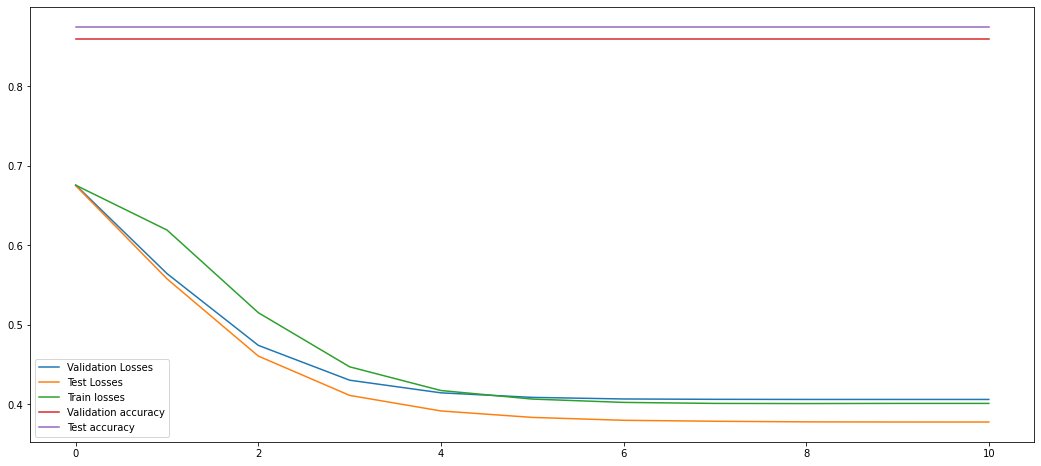

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(range(num_epochs+1),validation_losses,label="Validation Losses")
plt.plot(range(num_epochs+1),test_losses,label="Test Losses")
plt.plot(range(num_epochs+1),train_losses, label="Train losses")
plt.plot(range(num_epochs+1),validation_accuracies, label = "Validation accuracy")
plt.plot(range(num_epochs+1),test_accuracies, label = "Test accuracy")
plt.legend()
plt.show()

## Summary
Although our model has fairly good accuracy, we could not see a significant increase in performance after a few epochs.
As can be seen in the plot, losses gradually drop over the epochs but the accuracy stays roughly the same.

We tried to improve our model with the following tweaks:
- regularization techniques like dropout and activity regularization.
- optimizers like SGV and Adam
- normalization of our dataset values
- different data splits
- different data batches
- different depth and width of the network

Weirdly, different data splits seem to have a more significant effect on model performance than our applied optimization/regularization.

Our best performing model:
- regularizer: L1_L2
- optimizer: Adam
- data split: 60% train, 20% validation, 20% test
- batch size < 50